In [1]:
# Cell 1 – Imports & load data
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)

from xgboost import XGBClassifier

RANDOM_SEED = 42

BASE_DIR = "/mnt/c/Users/Home/Documents/PBA_Assignment"
csv_path = os.path.join(BASE_DIR, "data_model_preprocessing-PBA.csv")

print("CSV path:", csv_path)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


CSV path: /mnt/c/Users/Home/Documents/PBA_Assignment/data_model_preprocessing-PBA.csv
Shape: (122557, 31)


,WeekendOrder,Processing.Days,Distance_km,`Order Item Product Price`,`Order Item Quantity`,`Order Item Discount Rate`,`Order Region`Caribbean,`Order Region`Central Africa,`Order Region`Central America,`Order Region`East Africa,...,`Order Region`Southern Europe,`Order Region`US Center,`Order Region`West Africa,`Order Region`West Asia,`Order Region`West of USA,`Order Region`Western Europe,`Shipping Mode`Same Day,`Shipping Mode`Second Class,`Shipping Mode`Standard Class,Late_delivery_risk
0,0,3.0,18500.760815,327.75,1,0.04,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,3.0,11640.755465,327.75,1,0.07,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,2.0,16576.993966,327.75,1,0.09,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,6.0,15192.036863,327.75,1,0.10,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2.0,15431.281031,327.75,1,0.12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [2]:
# Cell 2 – Features & target
TARGET_COL = "Late_delivery_risk"

if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found.")

print("Target distribution:")
print(df[TARGET_COL].value_counts(normalize=True))

# Drop obvious ID columns if present
ID_CANDIDATES = ["OrderId", "Order Id", "order_id"]
id_cols = [c for c in ID_CANDIDATES if c in df.columns]

exclude_cols = [TARGET_COL] + id_cols
feature_cols = [c for c in df.columns if c not in exclude_cols]

print("\nID columns excluded:", id_cols)
print("Number of features:", len(feature_cols))
print("First 10 features:", feature_cols[:10])

X = df[feature_cols].copy()
X = X.apply(pd.to_numeric, errors="coerce")
if X.isna().any().any():
    X = X.fillna(X.mean())

X = X.values.astype(np.float32)
y = df[TARGET_COL].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)


Target distribution:
Late_delivery_risk
1    0.54861
0    0.45139
Name: proportion, dtype: float64

ID columns excluded: []
Number of features: 30
First 10 features: ['WeekendOrder', 'Processing.Days', 'Distance_km', '`Order Item Product Price`', '`Order Item Quantity`', '`Order Item Discount Rate`', '`Order Region`Caribbean', '`Order Region`Central Africa', '`Order Region`Central America', '`Order Region`East Africa']
X shape: (122557, 30)
y shape: (122557,)


In [3]:
# Cell 3 – Define models for cross-validation
# Logistic regression model (baseline) – sklearn version for CV
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=1000,
        solver="lbfgs",
        random_state=RANDOM_SEED,
    )),
])

# XGBoost classifier (advanced)
xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.0,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}


In [4]:
# Cell 4 – Run 5-fold cross-validation
from sklearn.model_selection import cross_validate

print("Running 5-fold CV for Logistic Regression...")
logreg_cv = cross_validate(
    logreg_clf, X, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)

print("Running 5-fold CV for XGBoost...")
xgb_cv = cross_validate(
    xgb_clf, X, y,
    cv=skf,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)


Running 5-fold CV for Logistic Regression...
Running 5-fold CV for XGBoost...


In [5]:
# Cell 5 – Summarise CV results + bar chart
def summarize_cv_results(name, cv_results):
    summary = {}
    for metric in scoring.keys():
        key = f"test_{metric}"
        scores = cv_results[key]
        summary[metric] = {
            "mean": scores.mean(),
            "std": scores.std()
        }
    summary_df = pd.DataFrame(summary).T
    summary_df.columns = [f"{name}_mean", f"{name}_std"]
    return summary_df

logreg_summary = summarize_cv_results("LogReg", logreg_cv)
xgb_summary = summarize_cv_results("XGB", xgb_cv)

cv_summary = pd.concat([logreg_summary, xgb_summary], axis=1)
cv_summary


,LogReg_mean,LogReg_std,XGB_mean,XGB_std
accuracy,0.951794,0.001341,0.956045,0.000732
precision,0.957011,0.002203,0.947631,0.002818
recall,0.955039,0.002513,0.973705,0.002316
f1,0.956020,0.001234,0.960484,0.000598
roc_auc,0.972466,0.000874,0.981795,0.000962


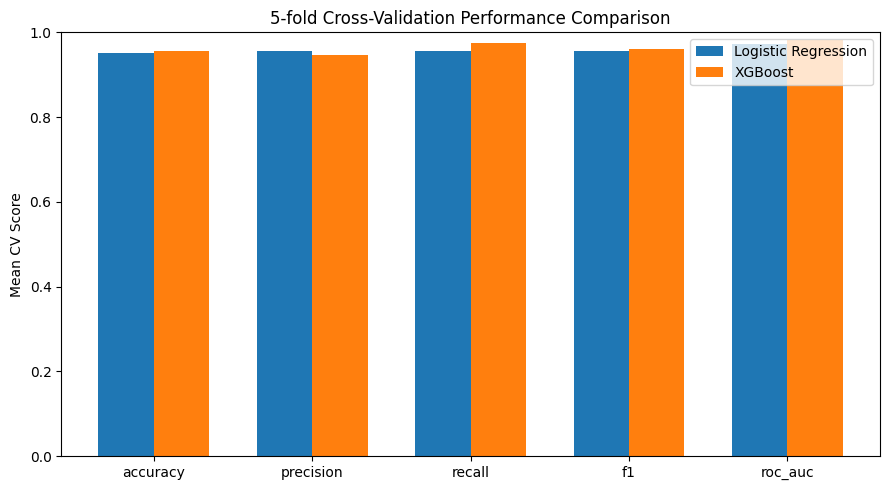

In [6]:
metrics_to_plot = ["accuracy", "precision", "recall", "f1", "roc_auc"]

logreg_means = [cv_summary.loc[m, "LogReg_mean"] for m in metrics_to_plot]
xgb_means    = [cv_summary.loc[m, "XGB_mean"] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x - width/2, logreg_means, width, label="Logistic Regression")
plt.bar(x + width/2, xgb_means, width, label="XGBoost")

plt.xticks(x, metrics_to_plot)
plt.ylabel("Mean CV Score")
plt.ylim(0, 1)
plt.title("5-fold Cross-Validation Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# Cell 6 – ROC curve comparison (single held-out test set)
# Recreate 60/20/20 split for ROC comparison
n_samples = X.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)

train_end = int(0.6 * n_samples)
val_end = int(0.8 * n_samples)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train size:", X_train.shape[0])
print("Val size  :", X_val.shape[0])
print("Test size :", X_test.shape[0])


Train size: 73534
Val size  : 24511
Test size : 24512


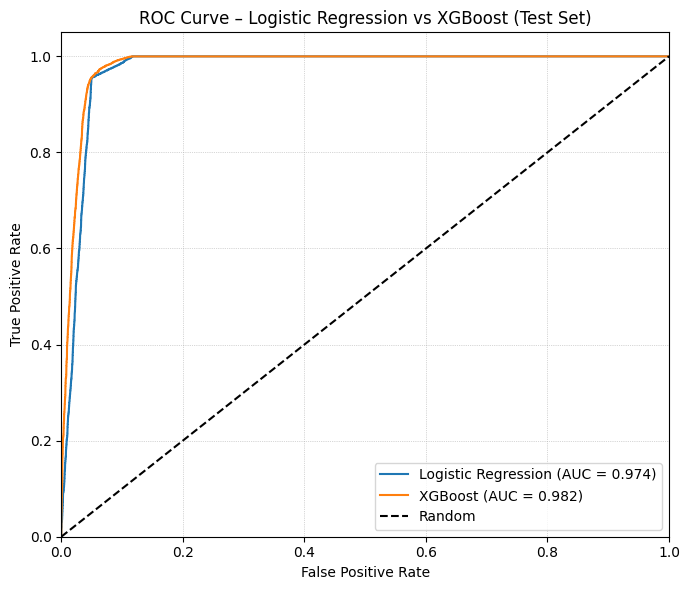

In [8]:
# Cell 7 – Fit both models on train and compute ROC on test
# Fit models on training set
logreg_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Probabilities for class 1 on test set
logreg_proba = logreg_clf.predict_proba(X_test)[:, 1]
xgb_proba    = xgb_clf.predict_proba(X_test)[:, 1]

# ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression vs XGBoost (Test Set)")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()
